In [12]:
import os
from pathlib import Path

import cv2 as cv
import matplotlib
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from yolov5.utils.plots import Annotator
from ultralytics import YOLO

from utils.edge import tooth_isolation
from utils.yolo import get_teeth_ROI

load_dotenv()
matplotlib.use('module://matplotlib_inline.backend_inline')

%matplotlib inline

YOLO_model_dir = Path(os.getenv('YOLO_MODEL_DIR'))
data_dir = Path(os.getenv('DATASET_DIR')) / 'DENTEX CHALLENGE 2023'


In [14]:
from utils.data import DentexDataset

dataset = DentexDataset(root_dir=data_dir)

img_path = dataset.img_paths[0]

len(dataset)


634

In [4]:
model = YOLO(YOLO_model_dir / '8-bound-v8.pt')

model



0: 320x640 1 13, 1 17, 1 23, 1 27, 1 33, 2 37s, 1 43, 1 47, 64.4ms
Speed: 2.2ms preprocess, 64.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


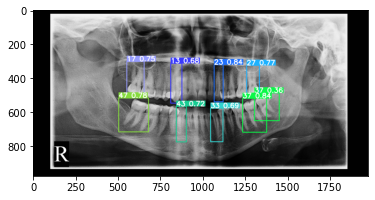

In [5]:
results = model(dataset[0][0])

plot = results[0].plot()

plt.imshow(plot)
plt.show()


In [8]:
save = False
rotation_fix = False
yolov8 = True


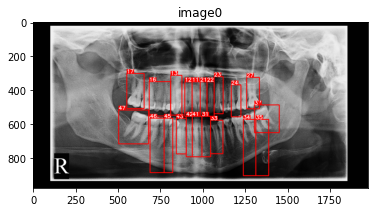

In [15]:
teeth_roi = get_teeth_ROI(results, yolov8=yolov8)

split_teeth = teeth_roi['split_teeth']
teeth_roi = teeth_roi['images']

tooth_position_dict = {
    0: 'left',
    1: 'middle',
    2: 'right'
}

teeth_region = {}
for file_name, data in teeth_roi.items():
    temp_region = {}
    for datum in data:
        flag = datum['flag']
        im = datum['image']
        offset = datum['offset']
        tooth_position = datum['tooth_position']

        im_g = cv.cvtColor(im, cv.COLOR_RGB2GRAY)

        isolation_data = tooth_isolation(im_g, flag=flag, filename=file_name, tooth_position=tooth_position,
                                         save=save,
                                         rotation_fix=rotation_fix)
        region = isolation_data['crop_regions']
        for k, v in region.items():
            xyxy = region[k]['xyxy']

            xyxy[0] += offset[0]
            xyxy[1] += offset[1]
            xyxy[2] += offset[0]
            xyxy[3] += offset[1]

            region[k]['xyxy'] = xyxy

        temp_region.update(region)
        temp_region.update(split_teeth[file_name])

        teeth_region[file_name] = temp_region

# Display bounding area
for file_name, data in teeth_region.items():
    im0 = cv.imread(img_path)
    annotator = Annotator(im0, line_width=3, example=file_name)
    for tooth_number, body in data.items():
        xyxy = body['xyxy']
        annotator.box_label(xyxy, str(tooth_number), color=(255, 0, 0))

    im1 = annotator.result()

    plt.imshow(im1)
    plt.title(file_name)
    plt.show()
